In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%matplotlib widget
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator

### Read the Data

In [2]:
data = pd.read_csv("/mnt/Data/code/machine_learning/course/intro_to_ML/intro_to_ML/project/CC GENERAL.csv")
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Remove **CUST_ID**, as it has no effect on the model.

In [3]:
data.drop(columns=["CUST_ID"], inplace=True)

## Pre-processing

### Handle missing values

Check the number of missing values in each column.


Two columns: **MINIMUM_PAYMENTS** and **CREDIT_LIMIT** has missing values.

|Column|Missing Numbers|
|-----------|--------------------------|
|**MININUM_PAYMENTS**|313|
|**CREDIT_LIMIT**|1|

In [4]:
data.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Missing value in **CREDIT_LIMIT** is replaced using the mode of values because its values are not continuous values and there exisit only certain number of credit limit.

In [5]:
data["CREDIT_LIMIT"].fillna(data["CREDIT_LIMIT"].mode()[0], inplace=True)

Missing values of **MINIMUM_PAYMENT** is replaced with the mean of the values because its values are continuous.

In [6]:
data["MINIMUM_PAYMENTS"].fillna(data["MINIMUM_PAYMENTS"].mean(), inplace=True)

Confirm the missing values are handled.

In [7]:
data.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

### Visualize the original data

In [8]:
def plot_data(data, title):
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],  linewidth=0.5);
    ax.set_xlabel('Z1')
    ax.set_ylabel('Z2')
    ax.set_zlabel('Z3')
    ax.set_title(title)
    plt.show()

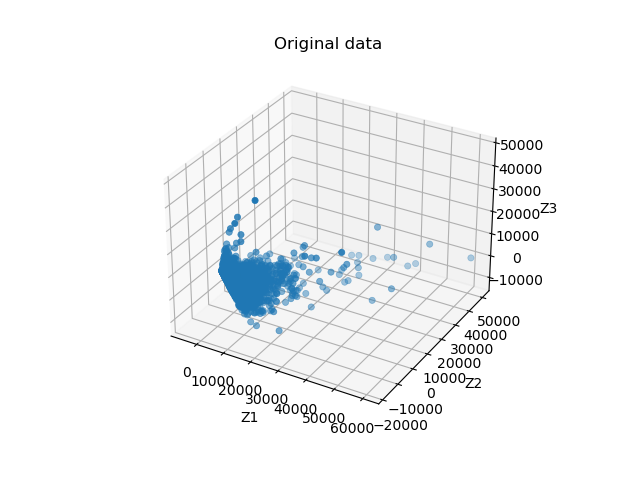

In [9]:
plot_data(data, "Original data")

### Handle outliers

Check there is outliers in the data.

In [10]:
def plot_column_boxplot(data, title):
    columns = data.columns
    fig, axs = plt.subplots(5, 4, figsize=(10, 10))
    fig.tight_layout(pad=2.0)

    for column, ax in zip(columns, axs.flat):
        ax.boxplot(data[column], labels=[column])
    fig.suptitle(title)
    fig.savefig(title + ".png")

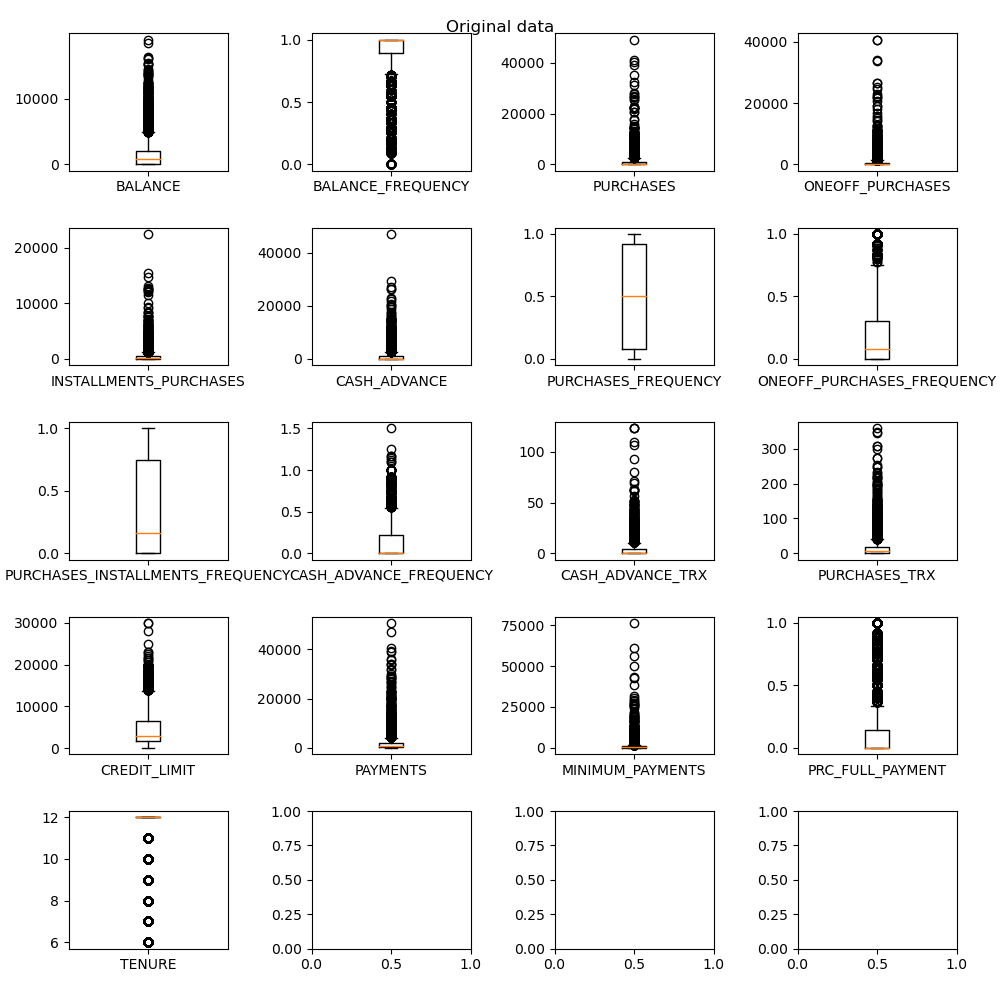

In [11]:
plot_column_boxplot(data, "Original data")

The outliers are detected using the inter quartile range. 

In [12]:
def outlier_detection(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)

    outliers = ( (data < minimum) | (data > maximum) )
    return outliers

There are several strategies such as mean, median and k-Nearest neighbors, etc, that can be used for handling missing data.

In [13]:
def remove_outliers(data):
    columns = data.columns.tolist()
    imp_data = data.copy()

    for column in columns:
        outliers = outlier_detection(imp_data[column])
        
        num_outliers = np.sum( outliers )
        num_total = imp_data[column].count()
        imp_data[column] = imp_data[column].mask(outliers, np.nan)

    imputer = KNNImputer(missing_values=np.nan)
        
    imp_data = imputer.fit_transform(imp_data)
    imp_data = pd.DataFrame(imp_data, columns=columns)
    return imp_data

In this project, k-Nearest Neighbors method is used as it is easy to implement and good option for small dataset.

In [14]:
no_outlier_data = remove_outliers(data)

### Handle skewness in data

In [15]:
def plot_column_hist_line(data, title):
    columns = data.columns
    fig, axs = plt.subplots(5, 4, figsize=(10, 10))
    fig.tight_layout(pad=3.0)

    for column, ax in zip(columns, axs.flat):
        ax.hist(data[column], density=True, alpha=0.5)
        sns.kdeplot(data[column], ax=ax, warn_singular=False)
    fig.suptitle(title)
    fig.savefig(title + ".png")

Check the skewness in each data column.

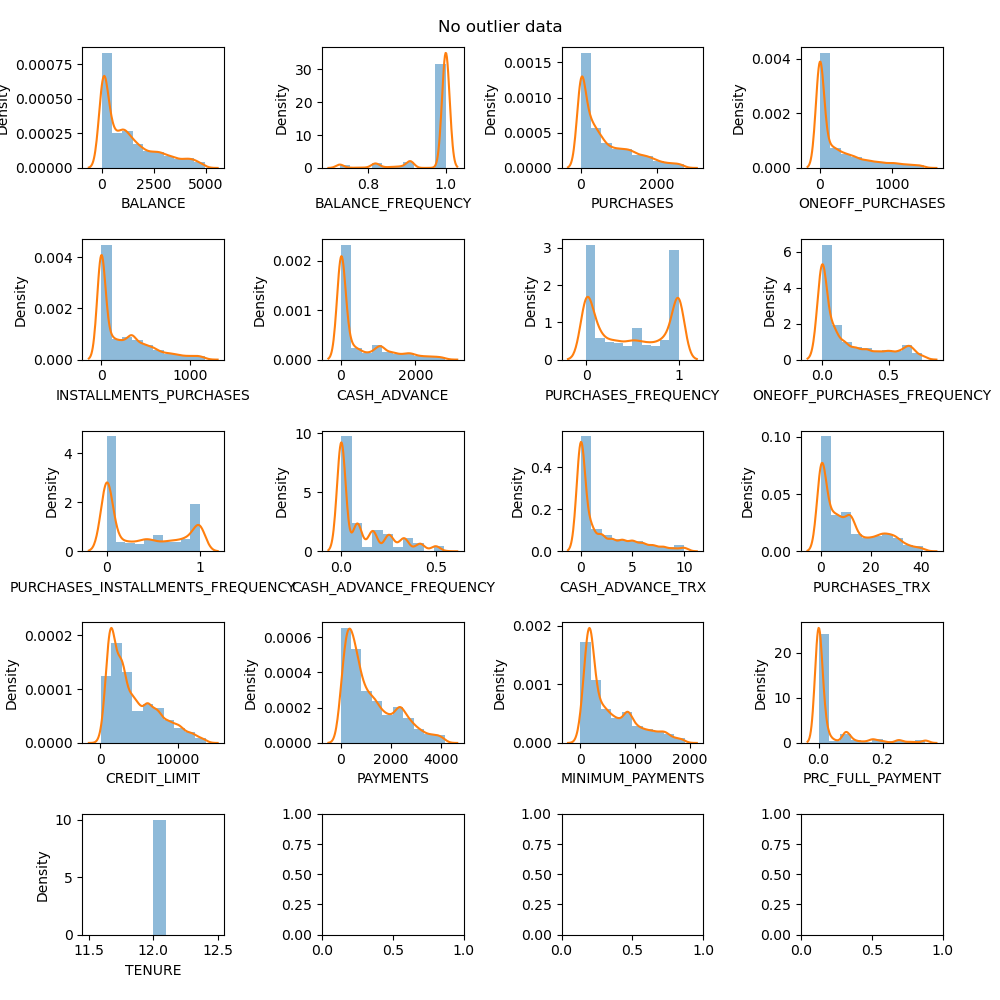

In [16]:
plot_column_hist_line(no_outlier_data, "No outlier data")

Remove the skewness using log1p.

In [17]:
def remove_skewness(data):
    columns = data.columns.tolist()
    
    transformer = FunctionTransformer(np.log1p)

    transform_data = transformer.transform(data)
    transform_data = pd.DataFrame(transform_data, columns=columns)
    return transform_data

In [18]:
unskew_data = remove_skewness(no_outlier_data)

It does not remove skewness completely but it is much better now.

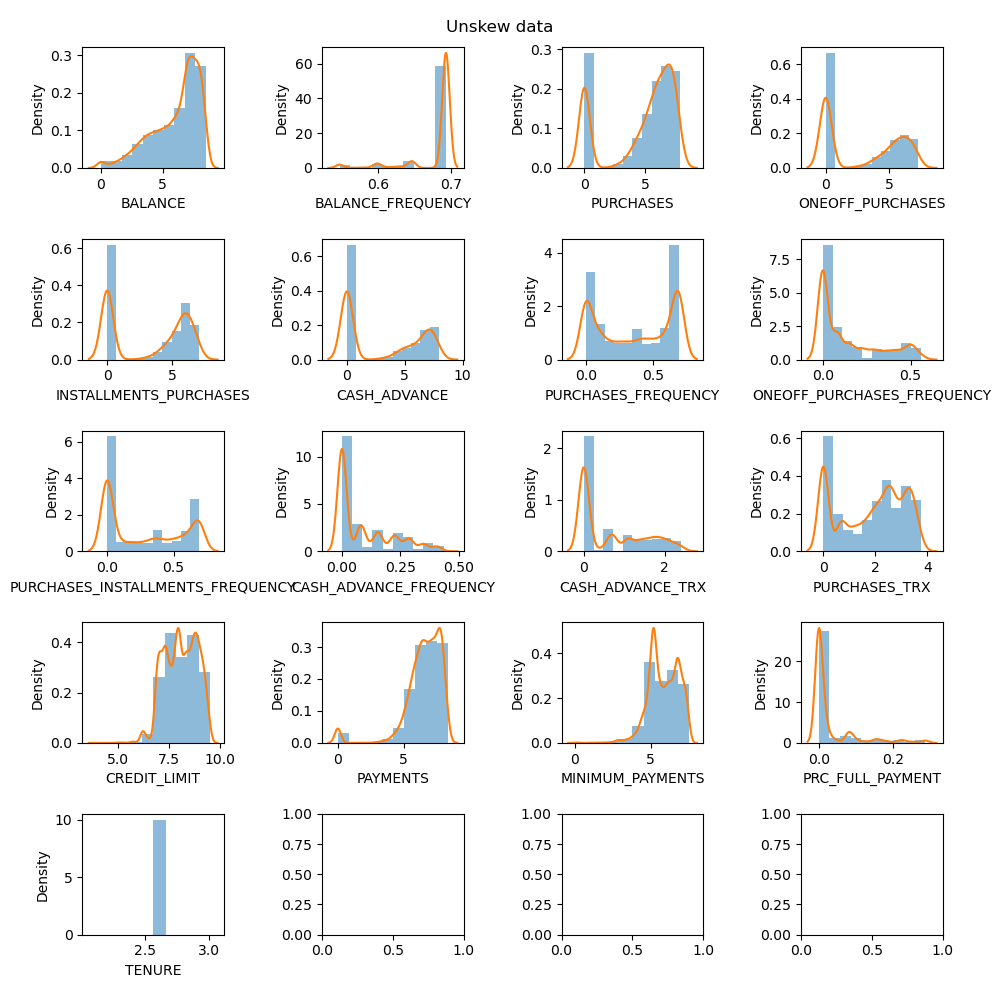

In [19]:
plot_column_hist_line(unskew_data, "Unskew data")

Visualize the unskew data

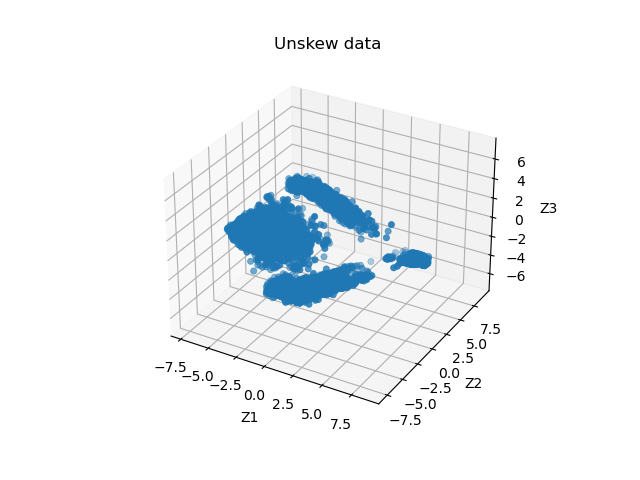

In [20]:
plot_data(unskew_data, "Unskew data")

### Reduce dimension

Dimension reduction technique can filter out some noise and reduce the risk of high-dimensional datasets being very sparse.

In [21]:
def reduce_dimensions(data):
    pca = PCA()
    pca.fit(data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
 
    d = np.argmax(cumsum >= 0.95) + 1

    plt.figure(figsize=(10, 5))
    plt.plot(cumsum, linewidth=3)
    plt.plot(d, cumsum[d], "ro")
    plt.plot([0, d], [cumsum[d], cumsum[d]], "k--")
    plt.plot([d, d],[cumsum[0], cumsum[d]], "k--")
    plt.xticks(range(0, len(data.columns)))
    plt.xlabel("Dimensions")
    plt.ylabel("Explained Variance")
    plt.plot()

    columns = ["Z" + str(i) for i in range(1, d+1)]
    
    pca = PCA(n_components=d)
    reduced_data = pca.fit_transform(data)
    reduced_data = pd.DataFrame(reduced_data, columns=columns)
    return reduced_data

New dimensions: 5


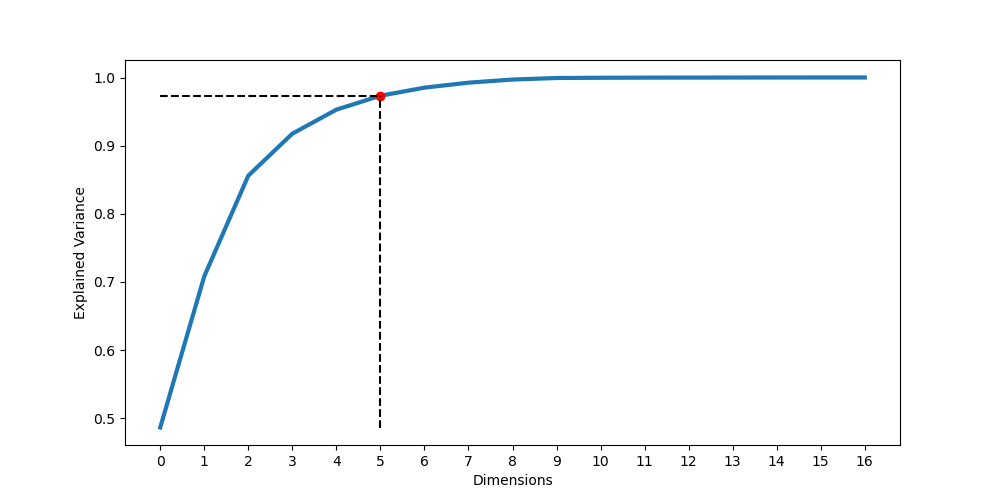

In [22]:
reduce_data = reduce_dimensions(unskew_data)
print(f"New dimensions: {len(reduce_data.columns)}")

## Modelling

### k-Means Clustering

Find the number of clusters using inertia.

In [25]:
def kmean_clustering_IN(data):
    columns = data.columns.tolist()
    random_states = [10, 20, 30, 40, 50]
    num_clusters = range(2, 21)
    inertia_history = dict()

    # Try several number of clusters
    for k in num_clusters:
        inertia = list()
        for rs in random_states:
            kmeans = KMeans(n_clusters=k, random_state=rs)
            kmeans.fit(data)
            inertia.append(kmeans.inertia_)
        avg_inertia = np.mean(inertia)
        inertia_history[k] = avg_inertia

    # Find the best number of clusters using elbow method
    x = list(inertia_history.keys())
    y = list(inertia_history.values())
    kneedle = KneeLocator(x, y, curve="convex", direction="decreasing")
    num_cluster = kneedle.elbow
    print(inertia_history[num_cluster])
    print(f"Number of clusters: {num_cluster}")

    # Train the model on the best number of clusters
    kmeans = KMeans(n_clusters=num_cluster, random_state=42)
    y_pred = kmeans.fit_predict(data).reshape(-1, 1)

    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

76491.00864206397
Number of clusters: 6


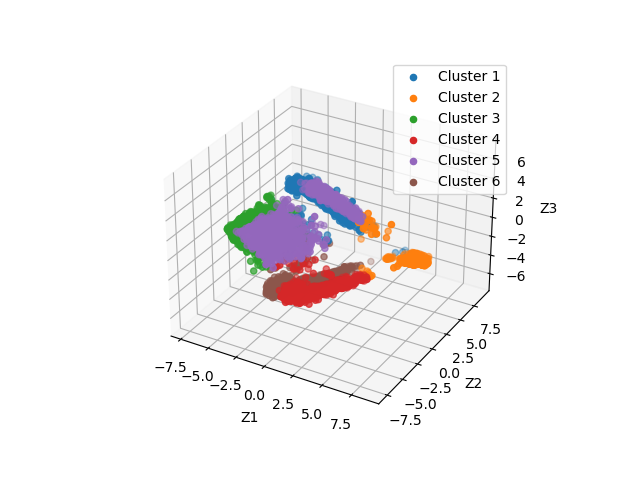

In [26]:
kmean_in_data = kmean_clustering_IN(reduce_data)
kmean_in_data.to_csv("final_kmean_in.csv", index=False)

Find the number of clusters using Daives Bouldin score.

In [ ]:
def kmean_clustering_DB(data):
    columns = data.columns.tolist()
    random_states = [10, 20, 30, 40, 50]
    num_clusters = range(2, 21)
    score_history = dict()

    # Try several number of clusters
    for k in num_clusters:
        scores = list()
        for rs in random_states:
            kmeans = KMeans(n_clusters=k, random_state=rs)
            kmeans.fit(data)
            scores.append(davies_bouldin_score(data, kmeans.labels_))
        avg_scores = np.mean(scores)
        score_history[k] = avg_scores

    # Find the best number of clusters using silhouette score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmin(y)]
    print(score_history[num_cluster])
    print(f"Number of clusters: {num_cluster}")

    # Train the model on the best number of clusters
    kmeans = KMeans(n_clusters=num_cluster, random_state=42)
    y_pred = kmeans.fit_predict(data).reshape(-1, 1)

    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
kmean_db_data = kmean_clustering_DB(reduce_data)
kmean_db_data.to_csv("final_kmean_db.csv", index=False)

Find the number of clusters using silhouette score.

In [27]:
def kmean_clustering_SH(data):
    columns = data.columns.tolist()
    random_states = [10, 20, 30, 40, 50]
    num_clusters = range(2, 21)
    score_history = dict()

    # Try several number of clusters
    for k in num_clusters:
        scores = list()
        for rs in random_states:
            kmeans = KMeans(n_clusters=k, random_state=rs)
            kmeans.fit(data)
            scores.append(silhouette_score(data, kmeans.labels_))
        avg_scores = np.mean(scores)
        score_history[k] = avg_scores

    # Find the best number of clusters using silhouette score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmax(y)]
    print(score_history[num_cluster])
    print(f"Number of clusters: {num_cluster}")

    # Train the model on the best number of clusters
    kmeans = KMeans(n_clusters=num_cluster, random_state=42)
    y_pred = kmeans.fit_predict(data).reshape(-1, 1)

    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns+ ["Cluster"])
    return result

0.5063120879571967
Number of clusters: 7


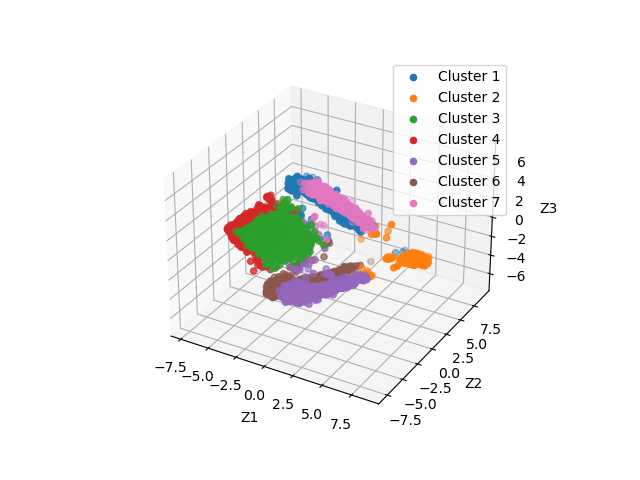

In [28]:
kmean_sh_data = kmean_clustering_SH(reduce_data)
kmean_sh_data.to_csv("final_kmean_sh.csv", index=False)

### DBSCAN Clusteirng

In [ ]:
def dbscan_clustering_DB(data):
    columns = data.columns.tolist()
    score_history = dict()
    eps_history = dict()
    min_pts_history = dict()
    min_pts = [5, 10, 20, 50, 100, 200]

    # Try several minimum points and eps
    for min_pt in min_pts:
        neighbors = NearestNeighbors(n_neighbors=min_pt)
        neighbors_fit = neighbors.fit(data)

        distances, indices = neighbors_fit.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        indices = range(0, len(distances))

        kneedle = KneeLocator(indices, distances, curve="convex", direction="increasing")
        eps = distances[kneedle.elbow]

        dbscan = DBSCAN(eps=eps, min_samples=min_pt)
        y_pred = dbscan.fit_predict(data)

        k = len(set(y_pred)) - (1 if -1 in y_pred else 0)

        score = davies_bouldin_score(data, y_pred)
        score_history[k] = score
        eps_history[k] = eps
        min_pts_history[k] = min_pt
    
    # Find the best number of clusters using silhouette score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmin(y)]
    print(f"Number of clusters: {num_cluster}")
    print(f"Best eps: {eps_history[num_cluster]}")
    print(f"Best min_pts: {min_pts_history[num_cluster]}")

    # Train the model on the best minimum points and eps
    dbscan = DBSCAN(eps=eps_history[num_cluster], min_samples=min_pts_history[num_cluster])
    y_pred = dbscan.fit_predict(data).reshape(-1, 1)
    
    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(-1,num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
dbscan_db_data = dbscan_clustering_DB(reduce_data)
dbscan_db_data.to_csv("final_dbscan_db.csv", index=False)

In [31]:
def dbscan_clustering_SH(data):
    columns = data.columns.tolist()
    score_history = dict()
    eps_history = dict()
    min_pts_history = dict()
    min_pts = [5, 10, 20, 50, 100, 200]

    # Try several minimum points and eps
    for min_pt in min_pts:
        neighbors = NearestNeighbors(n_neighbors=min_pt)
        neighbors_fit = neighbors.fit(data)

        distances, indices = neighbors_fit.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        indices = range(0, len(distances))

        kneedle = KneeLocator(indices, distances, curve="convex", direction="increasing")
        eps = distances[kneedle.elbow]

        dbscan = DBSCAN(eps=eps, min_samples=min_pt)
        y_pred = dbscan.fit_predict(data)

        k = len(set(y_pred)) - (1 if -1 in y_pred else 0)

        score = silhouette_score(data, y_pred)
        score_history[k] = score
        eps_history[k] = eps
        min_pts_history[k] = min_pt
    
    # Find the best number of clusters using silhouette score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmax(y)]
    print(score_history[num_cluster])
    print(f"Number of clusters: {num_cluster}")
    print(f"Best eps: {eps_history[num_cluster]}")
    print(f"Best min_pts: {min_pts_history[num_cluster]}")

    # Train the model on the best minimum points and eps
    dbscan = DBSCAN(eps=eps_history[num_cluster], min_samples=min_pts_history[num_cluster])
    y_pred = dbscan.fit_predict(data).reshape(-1, 1)
    
    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(-1,num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

0.44975147957323264
Number of clusters: 7
Best eps: 1.6523974697016661
Best min_pts: 100


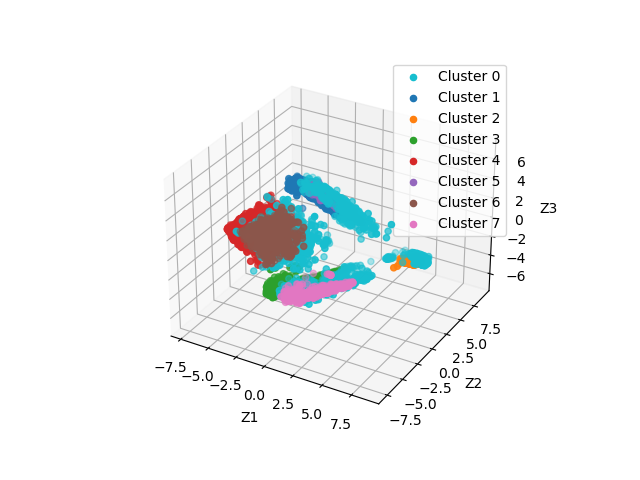

In [32]:
dbscan_sh_data = dbscan_clustering_SH(reduce_data)
dbscan_sh_data.to_csv("final_dbscan_sh.csv", index=False)

### Hierarchical Clustering

In [ ]:
def hierarchical_clustering_DB(data):
    columns = data.columns.tolist()
    num_clusters = range(2, 21)
    score_history = dict()

    # Try several number of clusters
    for k in num_clusters:
        hierarchical = AgglomerativeClustering(n_clusters=k, compute_distances=True)
        y_pred = hierarchical.fit_predict(data)

        score = davies_bouldin_score(data, y_pred)
        score_history[k] = score
    
    # Find the best number of clusters using davies bouldin score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmin(y)]
    print(f"Number of clusters: {num_cluster}")

    # Train the model on the best number of clusters
    hierarchical = AgglomerativeClustering(n_clusters=num_cluster, compute_distances=True)
    y_pred = hierarchical.fit_predict(data).reshape(-1, 1)
    
    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
hierarchical_db_data = hierarchical_clustering_DB(reduce_data)
hierarchical_db_data.to_csv("final_hierarchical_db.csv", index=False)

In [33]:
def hierarchical_clustering_SH(data):
    columns = data.columns.tolist()
    num_clusters = range(2, 21)
    score_history = dict()

    # Try several number of clusters
    for k in num_clusters:
        hierarchical = AgglomerativeClustering(n_clusters=k, compute_distances=True)
        y_pred = hierarchical.fit_predict(data)

        score = silhouette_score(data, y_pred)
        score_history[k] = score
    
    # Find the best number of clusters using silhouette score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmax(y)]
    print(score_history[num_cluster])
    print(f"Number of clusters: {num_cluster}")

    # Train the model on the best number of clusters
    hierarchical = AgglomerativeClustering(n_clusters=num_cluster, compute_distances=True)
    y_pred = hierarchical.fit_predict(data).reshape(-1, 1)
    
    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

0.49820928191710007
Number of clusters: 7


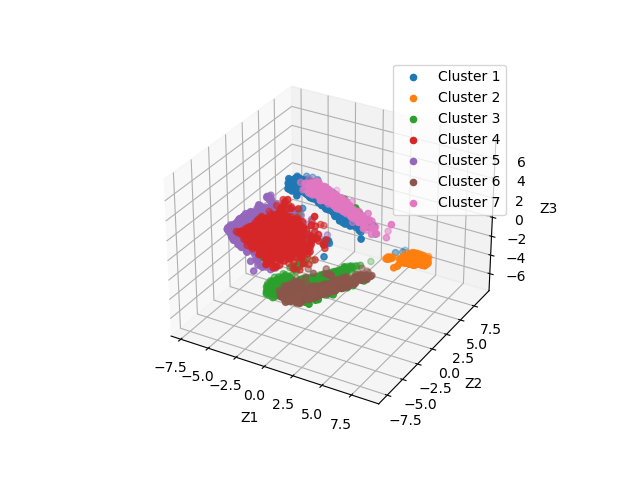

In [34]:
hierarchical_sh_data = hierarchical_clustering_SH(reduce_data)
hierarchical_sh_data.to_csv("final_hierarchical_sh.csv", index=False)

### HDBSCAN Clustering

In [ ]:
def hdbscan_clustering_DB(data):
    columns = data.columns.tolist()
    min_cluster_sizes = [5, 20, 50, 100, 200, 500, 1000, 1500]
    score_history = dict()
    min_cluster_history = dict()

    # Try several min cluster sizes
    for min_k_size in min_cluster_sizes:
        hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=min_k_size, min_samples=None, p=None, prediction_data=False)
        y_pred = hdbscan.fit_predict(data)

        k = len(set(y_pred)) - (1 if -1 in y_pred else 0)

        score = davies_bouldin_score(data, y_pred)
        score_history[k] = score
        min_cluster_history[k] = min_k_size
    
    # Find the best number of clusters using silhouette score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmin(y)]
    print(f"Number of clusters: {num_cluster}")

    # Train the model on the best minimum cluster size
    hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=min_cluster_history[num_cluster], min_samples=None, p=None, prediction_data=False)
    y_pred = hdbscan.fit_predict(data).reshape(-1,1)
    
    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.CSS4_COLORS.keys())
    for k in range(-1,num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
hdbscan_db_data = hdbscan_clustering_DB(reduce_data)
hdbscan_db_data.to_csv("final_hdbscan_db.csv", index=False)

In [35]:
def hdbscan_clustering_SH(data):
    columns = data.columns.tolist()
    min_cluster_sizes = [5, 20, 50, 100, 200, 500, 1000, 1500]
    score_history = dict()
    min_cluster_history = dict()

    # Try several min cluster sizes
    for min_k_size in min_cluster_sizes:
        hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=min_k_size, min_samples=None, p=None, prediction_data=False)
        y_pred = hdbscan.fit_predict(data)

        k = len(set(y_pred)) - (1 if -1 in y_pred else 0)

        score = silhouette_score(data, y_pred)
        score_history[k] = score
        min_cluster_history[k] = min_k_size
    
    # Find the best number of clusters using silhouette score
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmax(y)]
    print(score_history[num_cluster])
    print(f"Number of clusters: {num_cluster}")
    print("Min cluster size: ", min_cluster_history[num_cluster])

    # Train the model on the best minimum cluster size
    hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=min_cluster_history[num_cluster], min_samples=None, p=None, prediction_data=False)
    y_pred = hdbscan.fit_predict(data).reshape(-1,1)
    
    # Visualize the clusters
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.CSS4_COLORS.keys())
    for k in range(-1,num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

0.48583798716097276
Number of clusters: 10
Min cluster size:  20


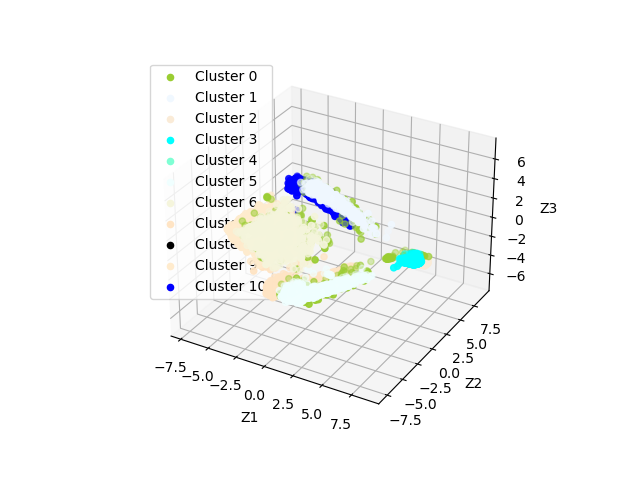

In [36]:
hdbscan_sh_data = hdbscan_clustering_SH(reduce_data)
hdbscan_sh_data.to_csv("final_hdbscan_sh.csv", index=False)

## Number of clusters according to different model using different metrics

|Model|Inertia|Daives Bouldin Score|Silhouette Score|
|---------|----------|--------------------------------|-------------------------|
|k-means|6|7|7|
|Hierarchical|-|2|7|
|DBSCAN|-|5|7|
|HDBSCAN|-|16|10|

## Evaluation

### k-Means Clustering

In [37]:
kmean_in_data = pd.read_csv("final_kmean_in.csv")
temp = kmean_in_data["Cluster"]

kmean_in_data = data.copy()
kmean_in_data["Cluster"] = temp

num_cluster = len(set(kmean_in_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("kmean_in_summary.txt", "a")
for k in range(num_cluster):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    kmean_in_data.groupby("Cluster").get_group(k).describe().to_csv(f"akm_{k}.csv")
    text = str(kmean_in_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()


Number of clusters:  6


In [38]:
df_list = list()
for i in range(6):
    df = pd.read_csv(f"akm_{i}.csv")
    df_list.append(df)

columns = df_list[0].columns.tolist()
columns.pop(0)
print(columns)

column_df_list = list()
for column in columns:
    new_df = pd.DataFrame()
    new_df["Type"] = df_list[0]['Unnamed: 0'].tolist()
    for i in range(6):
        new_df[f"Cluster {i+1}"] = df_list[i][column].values.tolist()
    column_df_list.append(new_df)

aa = pd.concat(column_df_list, axis=0)
aa.to_csv("kmean_in_summary.csv", index=False)
    


['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'Cluster']


In [ ]:
kmean_sh_data = pd.read_csv("final_kmean_sh.csv")
temp = kmean_sh_data["Cluster"]

kmean_sh_data = data.copy()
kmean_sh_data["Cluster"] = temp

num_cluster = len(set(kmean_sh_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("kmean_sh_summary.txt", "a")
for k in range(num_cluster):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    kmean_sh_data.groupby("Cluster").get_group(k).describe().to_csv(f"akm_{k}.csv")
    text = str(kmean_sh_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

In [ ]:
df_list = list()
for i in range(7):
    df = pd.read_csv(f"akm_{i}.csv")
    df_list.append(df)

columns = df_list[0].columns.tolist()
columns.pop(0)
print(columns)

column_df_list = list()
for column in columns:
    new_df = pd.DataFrame()
    new_df["Type"] = df_list[0]['Unnamed: 0'].tolist()
    for i in range(7):
        new_df[f"Cluster {i+1}"] = df_list[i][column].values.tolist()
    column_df_list.append(new_df)

aa = pd.concat(column_df_list, axis=0)
aa.to_csv("kmean_sh_summary.csv", index=False)
    


In [ ]:
kmean_db_data = pd.read_csv("final_kmean_db.csv")
temp = kmean_db_data["Cluster"]

kmean_db_data = data.copy()
kmean_db_data["Cluster"] = temp

num_cluster = len(set(kmean_db_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("kmean_db_summary.txt", "a")
for k in range(num_cluster):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    text = str(kmean_db_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

### DBSCAN Clustering

In [ ]:
dbscan_db_data = pd.read_csv("final_dbscan_db.csv")
temp = dbscan_db_data["Cluster"]

dbscan_db_data = data.copy()
dbscan_db_data["Cluster"] = temp

num_cluster = len(set(dbscan_db_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("dbscan_db_summary.txt", "a")
for k in range(num_cluster-1):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    dbscan_db_data.groupby("Cluster").get_group(k).describe().to_csv(f"akm_{k}.csv")
    text = str(dbscan_db_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

In [ ]:
df_list = list()
for i in range(5):
    df = pd.read_csv(f"akm_{i}.csv")
    df_list.append(df)

columns = df_list[0].columns.tolist()
columns.pop(0)
print(columns)

column_df_list = list()
for column in columns:
    new_df = pd.DataFrame()
    new_df["Type"] = df_list[0]['Unnamed: 0'].tolist()
    for i in range(5):
        new_df[f"Cluster {i+1}"] = df_list[i][column].values.tolist()
    column_df_list.append(new_df)

aa = pd.concat(column_df_list, axis=0)
aa.to_csv("dbscan_db_summary.csv", index=False)
    


In [ ]:
dbscan_db_data["Cluster"].value_counts()

In [ ]:
dbscan_sh_data = pd.read_csv("final_dbscan_sh.csv")
temp = dbscan_sh_data["Cluster"]

dbscan_sh_data = data.copy()
dbscan_sh_data["Cluster"] = temp

num_cluster = len(set(dbscan_sh_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("dbscan_sh_summary.txt", "a")
for k in range(num_cluster-1):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    text = str(dbscan_sh_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

### HDBSCAN

In [ ]:
hdbscan_db_data = pd.read_csv("final_hdbscan_db.csv")
temp = hdbscan_db_data["Cluster"]

hdbscan_db_data = data.copy()
hdbscan_db_data["Cluster"] = temp

num_cluster = len(set(hdbscan_db_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("hdbscan_db_summary.txt", "a")
for k in range(num_cluster-1):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    text = str(hdbscan_db_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

In [ ]:
hdbscan_sh_data = pd.read_csv("final_hdbscan_sh.csv")
temp = hdbscan_sh_data["Cluster"]

hdbscan_sh_data = data.copy()
hdbscan_sh_data["Cluster"] = temp

num_cluster = len(set(hdbscan_sh_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("hdbscan_sh_summary.txt", "a")
for k in range(num_cluster-1):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    text = str(hdbscan_sh_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

### Hierarchical Clustering

In [ ]:
hierarchical_db_data = pd.read_csv("final_hierarchical_db.csv")
temp = hierarchical_db_data["Cluster"]

hierarchical_db_data = data.copy()
hierarchical_db_data["Cluster"] = temp

num_cluster = len(set(hierarchical_db_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("hierarchical_db_summary.txt", "a")
for k in range(num_cluster):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    text = str(hierarchical_db_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

In [ ]:
hierarchical_sh_data = pd.read_csv("final_hierarchical_sh.csv")
temp = hierarchical_sh_data["Cluster"]

hierarchical_sh_data = data.copy()
hierarchical_sh_data["Cluster"] = temp

num_cluster = len(set(hierarchical_sh_data["Cluster"]))
print("Number of clusters: ", num_cluster)

f = open("hierarchical_sh_summary.txt", "a")
for k in range(num_cluster):
    f.write(f"\n\nCluster {k+1}\n----------------\n")
    text = str(hierarchical_sh_data.groupby("Cluster").get_group(k).describe()) + "\n\n"
    f.write(text)
f.close()

In [ ]:
plot_column_boxplot(data, "Original Data Boxplot")

In [ ]:
plot_column_hist_line(data, "Original Data Histogram")

In [ ]:
kmean_in_data

In [ ]:
fig = plt.figure(figsize=(16, 16))
fig.tight_layout(pad=1.0)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(reduce_data)

ax = fig.add_subplot(2, 3, 1, projection='3d')
y_pred = kmean_in_data["Cluster"].to_numpy().reshape(-1, 1)
num_cluster = len(set(kmean_in_data["Cluster"]))
X = np.concatenate([X_reduced, y_pred], axis=1)
colors = list(mcolors.TABLEAU_COLORS.keys())
for k in range(num_cluster):
    rows = np.where(X[:, 3] == k)
    ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
ax.set_xlabel("Z1")
ax.set_ylabel("Z2")
ax.set_zlabel("Z3")
ax.set_title("K-Means Inertia")
ax.legend()


ax = fig.add_subplot(2, 3, 2, projection='3d')
y_pred = kmean_sh_data["Cluster"].to_numpy().reshape(-1, 1)
num_cluster = len(set(kmean_sh_data["Cluster"]))
X = np.concatenate([X_reduced, y_pred], axis=1)
colors = list(mcolors.TABLEAU_COLORS.keys())
for k in range(num_cluster):
    rows = np.where(X[:, 3] == k)
    ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
ax.set_xlabel("Z1")
ax.set_ylabel("Z2")
ax.set_zlabel("Z3")
ax.set_title("K-Means Silhouette")
ax.legend()


ax = fig.add_subplot(2, 3, 3, projection='3d')
y_pred = hierarchical_sh_data["Cluster"].to_numpy().reshape(-1, 1)
num_cluster = len(set(hierarchical_sh_data["Cluster"]))
X = np.concatenate([X_reduced, y_pred], axis=1)
colors = list(mcolors.TABLEAU_COLORS.keys())
for k in range(num_cluster):
    rows = np.where(X[:, 3] == k)
    ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
ax.set_xlabel("Z1")
ax.set_ylabel("Z2")
ax.set_zlabel("Z3")
ax.set_title("Hierarchical Silhouette")
ax.legend()

ax = fig.add_subplot(2, 3, 4, projection='3d')
y_pred = dbscan_sh_data["Cluster"].to_numpy().reshape(-1, 1)
num_cluster = len(set(dbscan_sh_data["Cluster"]))
X = np.concatenate([X_reduced, y_pred], axis=1)
colors = list(mcolors.TABLEAU_COLORS.keys())
for k in range(-1,num_cluster-1):
    if k == -1:
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Outliers", color=colors[k])
    else:
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
ax.set_xlabel("Z1")
ax.set_ylabel("Z2")
ax.set_zlabel("Z3")
ax.set_title("DBSCAN Silhouette")
ax.legend()


ax = fig.add_subplot(2, 3, 5, projection='3d')
y_pred = hdbscan_sh_data["Cluster"].to_numpy().reshape(-1, 1)
num_cluster = len(set(hdbscan_sh_data["Cluster"]))
X = np.concatenate([X_reduced, y_pred], axis=1)
colors = list(mcolors.TABLEAU_COLORS.keys())
for k in range(-1,num_cluster-1):
    if k == -1:
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Outliers", color=colors[k])
    else:
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
ax.set_xlabel("Z1")
ax.set_ylabel("Z2")
ax.set_zlabel("Z3")
ax.set_title("HDBSCAN Silhouette")
ax.legend()
plt.savefig("clusters.png")
plt.show()